# Multi-organ c2l analysis

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import os,sys
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.sparse
import anndata

In [8]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/spatial_mapping_EDA/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    

In [9]:
# ## Directory to save intermediate outputs
# writedir = "/nfs/team205/ed6/data/Fetal_immune/PAGA_FA_outs/"
# if not os.path.exists(writedir):
#     os.mkdir(writedir)    

In [10]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [11]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Activate the anndata2ri conversion between SingleCellExperiment and AnnData

In [12]:
anndata2ri.activate()

In [13]:
%load_ext rpy2.ipython

In [14]:
%%R
library(tidyverse)

### Plotting utils

In [15]:
def _spatial_plot_lib(adata_vis, lib, color_by=None, **kwargs):
    with matplotlib.rc_context({"axes.facecolor": "black"}):
        s_ind = adata_vis.obs['sample'] == lib
        s_keys = list(adata_vis.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[lib in i for i in s_keys]][0]
        adata_small = adata_vis[s_ind, :].copy()
        sc.pl.spatial(adata_small, library_id=s_spatial,
                                **kwargs)
        
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value, return_list=False):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)
    if return_list:
        return(anno_order)
    

In [16]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :].copy()
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

def plot_spatial_per_cell_type(adata, 
                                   cell_type='total_counts',
                                   samples=['WSSS_F_IMMsp9838712', 'WSSS_F_IMMsp9838717', 
                                             'WSSS_F_IMMsp9838710', 
                                             'WSSS_F_IMMsp9838715', 
                                            'WSSS_F_IMMsp9838711', 'WSSS_F_IMMsp9838716'],
                                  ncol=3, prefix=''):
        n_samples = len(samples)
        nrow = int(np.ceil(n_samples / ncol))
        fig, axs = plt.subplots(nrow, ncol, figsize=(18, 8))
        if nrow == 1:
            axs = axs.reshape((1, ncol))

        col_name = f'{prefix}{cell_type}'
        vmax = np.quantile(adata[adata.obs["sample"].isin(samples)].obs[col_name].values, 0.992)
        adata.obs[cell_type] = adata.obs[col_name].copy()

        from itertools import chain
        ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))

        for i, s in enumerate(samples):
            sp_data_s = select_slide(adata, s, s_col='sample')
            sc.pl.spatial(sp_data_s, cmap='magma',
                          color=cell_type, 
                          size=1.3, img_key='hires', alpha_img=1,
                          vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                                )
            axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)

        fig.tight_layout(pad=0.5)

        return fig


### Read results

In [17]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
anno_groups_dict_rev = {"_".join(k.split("/")):v for k,v in anno_groups_dict_rev.items()}

In [18]:
def read_c2l(c2l_outdir):
    adata_vis = sc.read_h5ad(c2l_outdir + "sp.h5ad")

    adata_vis.obs["Organ"] = adata_vis.obs["Organ"].str[0:2]

    ## Add total cell abundance
    adata_vis.obs['total_cell_abundance'] = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1).flatten()

    # add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
    # to adata.obs with nice names for plotting
    # adata_vis.obs[adata_vis.uns['mod']['factor_names']] = (adata_vis.obsm['q05_cell_abundance_w_sf'].T/adata_vis.obs["total_cell_abundance"]).T
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf'].copy()

    ## Make metadata table for libraries
    vis_sample_metadata = adata_vis.obs[["sample", 'Organ', "Age_PCW"]].drop_duplicates()
    vis_sample_metadata.index = vis_sample_metadata['sample'].copy()
    vis_sample_metadata = vis_sample_metadata.drop("sample", 1)

    ## Ref celltypes info
    celltypes_df = pd.DataFrame(adata_vis.uns['mod']['factor_names'], columns=['annotation'])
    celltypes_df['anno_group'] = [anno_groups_dict_rev[c] if c in anno_groups_dict_rev.keys() else "STROMAL" for c in celltypes_df.annotation]
    celltypes_df['stromal_organ'] = np.nan
    celltypes_df.loc[celltypes_df['anno_group'] == "STROMAL", "stromal_organ"] = [x[-1] for x in celltypes_df[celltypes_df['anno_group'] == "STROMAL"].annotation.str.split("_")]

    celltypes_df.index = celltypes_df['annotation'].copy()
    return(adata_vis, celltypes_df, vis_sample_metadata)

In [26]:
def read_nmf(c2l_outdir, n_fact, out_type='ct_fractions'):
    nmf_outdir = c2l_outdir + 'CoLocatedComb/' + os.listdir(c2l_outdir + 'CoLocatedComb/')[0]
    if len(os.listdir(c2l_outdir + 'CoLocatedComb/')) > 1:
        nmf_outdir = c2l_outdir + 'CoLocatedComb/' + os.listdir(c2l_outdir + 'CoLocatedComb/')[1]
    if out_type == 'ct_fractions':
        ct_frac_outdir = nmf_outdir + "/cell_type_fractions_mean/"
        fact_mat = [x for x in os.listdir(ct_frac_outdir) if "n_fact" + str(n_fact) in x][0]
        out = pd.read_csv(ct_frac_outdir + fact_mat, index_col=0)
    elif out_type == "location":
        loc_outdir = nmf_outdir + "/location_factors_mean/"
        fact_mat = [x for x in os.listdir(loc_outdir) if "n_fact" + str(n_fact) in x][0]
        out = pd.read_csv(loc_outdir + fact_mat, index_col=0)
    return(out)

In [20]:
## Find celltypes where the max abundance in each slide is below a defined threshold
# (to exclude from co-location analysis)
def get_undetected_cts(adata_vis, vis_sample_metadata, detection_thresh = 0.15):
    detected_ct_df = pd.DataFrame(index=adata_vis.obsm['q05_cell_abundance_w_sf'].columns.values)
    for s in adata_vis.obs['sample'].unique():
        slide_q05_abundance = adata_vis[adata_vis.obs['sample'] == s].obsm['q05_cell_abundance_w_sf']
        is_detected = pd.Series(np.quantile(slide_q05_abundance, 0.992, axis=0))
        is_detected.index = detected_ct_df.index
        is_detected[is_detected < detection_thresh] = 0
        is_detected.name = s
        detected_ct_df = pd.concat([detected_ct_df, is_detected], 1)

    detected_ct_df.index = [x[1] for x in detected_ct_df.index.str.split('q05cell_abundance_w_sf_')]
    detected_ct_df = detected_ct_df[adata_vis.obs['sample'].unique()]

    undetected_cts = detected_ct_df[detected_ct_df.sum(1)==0].index
    return(undetected_cts)

In [21]:
def get_colocation_from_nmf(adata_vis, vis_sample_metadata, c2l_outdir, n_factors, min_frac = 0.2, detection_thresh=0.15):
    ## Read celltype fractions 
    nmf_fractions = read_nmf(c2l_outdir, n_fact=n_factors)
    ## Exclude undetected cts
    exclude_cts = get_undetected_cts(adata_vis, vis_sample_metadata, detection_thresh=detection_thresh)
    nmf_fractions = nmf_fractions[~nmf_fractions.index.isin(exclude_cts)]
    ## Filter by minimum fraction associated to factor 
    nmf_fractions = nmf_fractions.mask(nmf_fractions < min_frac, other=0)
    coloc_df = nmf_fractions.mask(nmf_fractions > 0, other=1)
    coloc_df.columns = ['fact_'+str(i) for i in range(n_factors)]
    return(coloc_df)

In [22]:
def pick_n_factors(c2l_outdir, n_fact_range=range(10,20)):
    max_cors = []
    for n in n_fact_range:
        nmf_fractions = read_nmf(c2l_outdir, n_fact=n)
        fact_cors = np.corrcoef(nmf_fractions.T)
        np.fill_diagonal(fact_cors, 0)
        max_cor = fact_cors.max()
        max_cors.append(max_cor)
    return(n_fact_range[np.argmin(max_cors)])



In [23]:
multiorgan_c2l_outdir = '/nfs/team205/vk7/sanger_projects/collaborations/pan_fetal_immune_mapping/results/spatial_mapping_multiorgan_tissuefilter_epochs50k_alphatest20/'

In [24]:
## Read full c2l output
adata_vis_full, celltypes_df_full, vis_sample_metadata_full = read_c2l(multiorgan_c2l_outdir)

### Are stromal cells more frequently mapped to the right organ?

In [881]:
stromal_cts = celltypes_df.annotation[(celltypes_df.anno_group=="STROMAL")]
org_stromal_cts = celltypes_df.annotation[(celltypes_df.anno_group=="STROMAL") & (celltypes_df.stromal_organ==org)].values
other_stromal_cts = celltypes_df.annotation[(celltypes_df.anno_group=="STROMAL") & (~celltypes_df.annotation.isin(org_stromal_cts))].values

stromal_abundance_df = adata_vis.obs[["sample", "Organ", "total_cell_abundance"] + list(stromal_cts)]
stromal_abundance_df['total_stromal_cell_abundance'] = stromal_abundance_df[stromal_cts].sum(1).copy()

celltypes_df = celltypes_df.astype("str")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [882]:
%%R -i stromal_abundance_df
dim(stromal_abundance_df)

[1] 12957    70


In [883]:
%%R -i celltypes_df
#     mutate(est_cell_abundance = ((est_cell_abundance- min(est_cell_abundance)))/(max(est_cell_abundance) - min(est_cell_abundance))) %>%
pl_df <- stromal_abundance_df %>%
    rownames_to_column("spot_id") %>%
    pivot_longer(cols=-c('spot_id','sample', "Organ", "total_cell_abundance", "total_stromal_cell_abundance"), names_to="annotation", values_to="est_cell_abundance") %>%
    left_join(celltypes_df) %>%
#     group_by(annotation) %>%
#     mutate(est_cell_abundance = est_cell_abundance/sum(est_cell_abundance)) %>%
#     ungroup() %>%
    mutate(est_cell_abundance = est_cell_abundance/total_stromal_cell_abundance) %>%
    group_by(spot_id, sample, Organ, annotation, stromal_organ) %>%
    summarise(total_est_cell_abundance = sum(est_cell_abundance)) %>%
    group_by(sample, Organ, annotation, stromal_organ) %>%
    summarise(total_est_cell_abundance = mean(total_est_cell_abundance)) 
    
    

Joining, by = "annotation"
`summarise()` has grouped output by 'spot_id', 'sample', 'Organ', 'annotation'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'Organ', 'annotation'. You can override using the `.groups` argument.


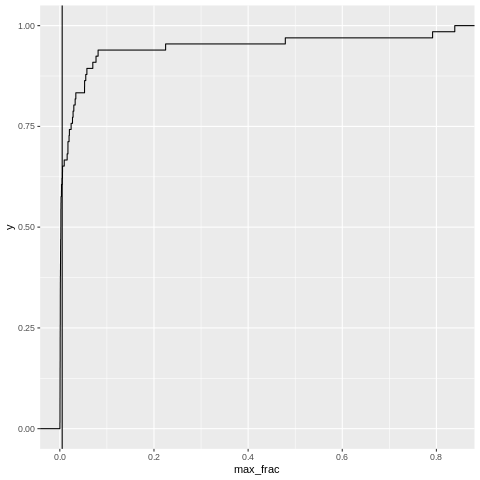

In [884]:
%%R
pl_df %>%
 group_by(annotation) %>%
    summarise(max_frac=max(total_est_cell_abundance)) %>%
    ggplot(aes(max_frac)) +
    stat_ecdf() +
    geom_vline(xintercept=0.005)

In [885]:
%%R
pl_df <- pl_df %>%
    group_by(annotation) %>%
    filter(max(total_est_cell_abundance) > 0.005) %>%
    ungroup() %>%
    group_by(annotation, stromal_organ) %>%
    mutate(total_est_cell_abundance = (total_est_cell_abundance - min(total_est_cell_abundance))/(max(total_est_cell_abundance) - min(total_est_cell_abundance)))

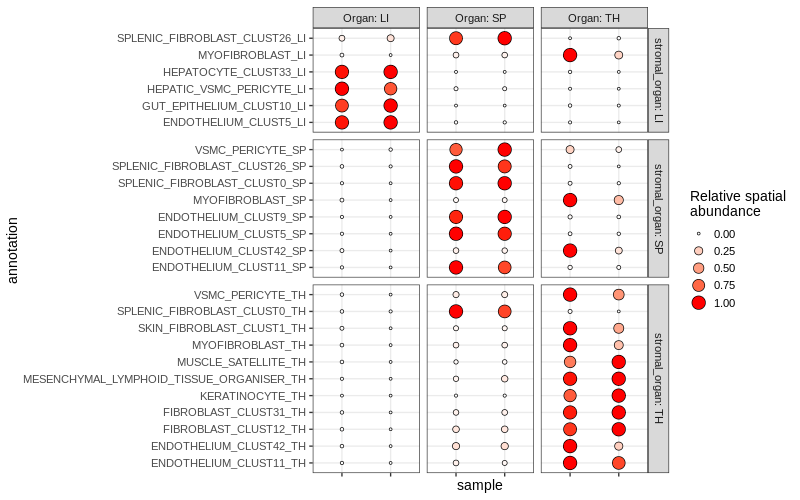

In [888]:
%%R -h 500 -w 800
pl_df %>%
 ggplot(aes(sample,annotation, fill=total_est_cell_abundance, size=total_est_cell_abundance)) +
    geom_point(shape=21) + 
    facet_grid(stromal_organ~Organ, scales='free', labeller='label_both', space="free") +
    scale_fill_gradient2(high="red", name='Relative spatial\nabundance',
                         limits=c(0, 1), breaks=seq(0, 1, by=0.25)) +
    scale_size(name='Relative spatial\nabundance',
                         limits=c(0, 1), breaks=seq(0, 1, by=0.25)) +
    guides(fill= guide_legend(), size=guide_legend()) +
    theme_bw(base_size = 14) +
    theme(axis.text.x = element_blank()) 
#     ggsave(paste0(figdir, 'stromal_cell_abundance_by_organ.pdf'), width=10, height=8)

## Colocation from cell abundance NMF on multi-organ reference

In [27]:
## Read cell type fractions
n = pick_n_factors(multiorgan_c2l_outdir)
nmf_fractions = read_nmf(multiorgan_c2l_outdir, n_fact=n)

## Read fraction values to locations
nmf_mat = read_nmf(multiorgan_c2l_outdir, n_fact=n, out_type='location')
adata_vis_full.obsm["NMF"] = nmf_mat.loc[adata_vis_full.obs_names]

In [28]:
## Assign each factor to one organ 
# (where max value of factor, empirically most factors can be connected to one organ)
all_f_df = pd.DataFrame()
all_org_mean_fact = pd.DataFrame()
for factor in ["fact_" + str(x) for x in range(0,n)]:
    adata_vis_full.obs[factor] = adata_vis_full.obsm["NMF"].loc[:,'mean_nUMI_factors' + factor]
    fact_df = adata_vis_full.obs[['sample', factor]]
#     fact_df[factor] = fact_df[factor].mask(fact_df[factor] < min_frac, 0)
    org_mean_fact = fact_df.groupby('sample').max()
    all_org_mean_fact = pd.concat([all_org_mean_fact, org_mean_fact], 1)
    f_df = pd.DataFrame([factor, org_mean_fact.idxmax().values[0], org_mean_fact.max().values[0]]).T
    all_f_df = pd.concat([all_f_df, f_df])

all_f_df.columns = ["factor", "top_organ", "top_organ_mean_nUMI"]

In [29]:
all_org_mean_fact.index = all_org_mean_fact.index.astype("str") + "_" + vis_sample_metadata_full.loc[all_org_mean_fact.index]['Organ']

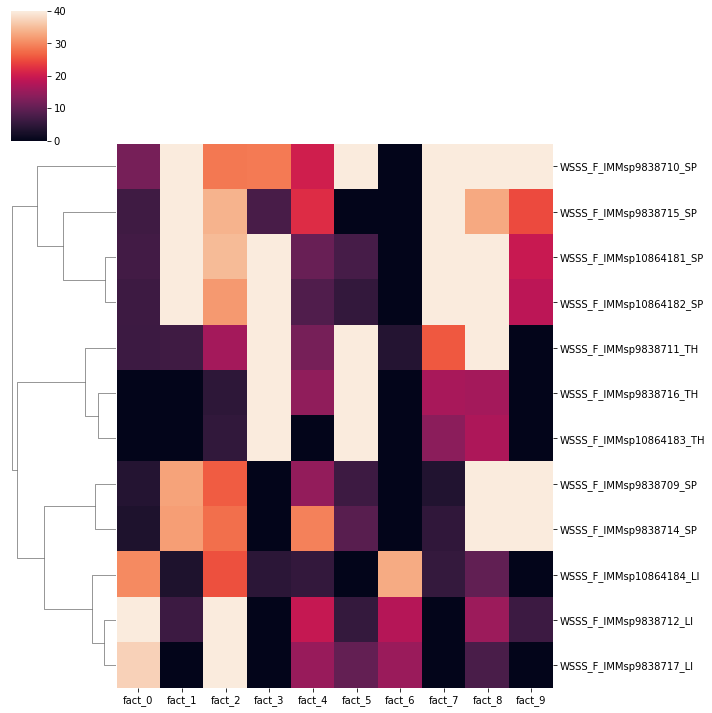

In [30]:
sns.clustermap(all_org_mean_fact.mask(all_org_mean_fact < 3, 0), col_cluster=False, vmax=40)

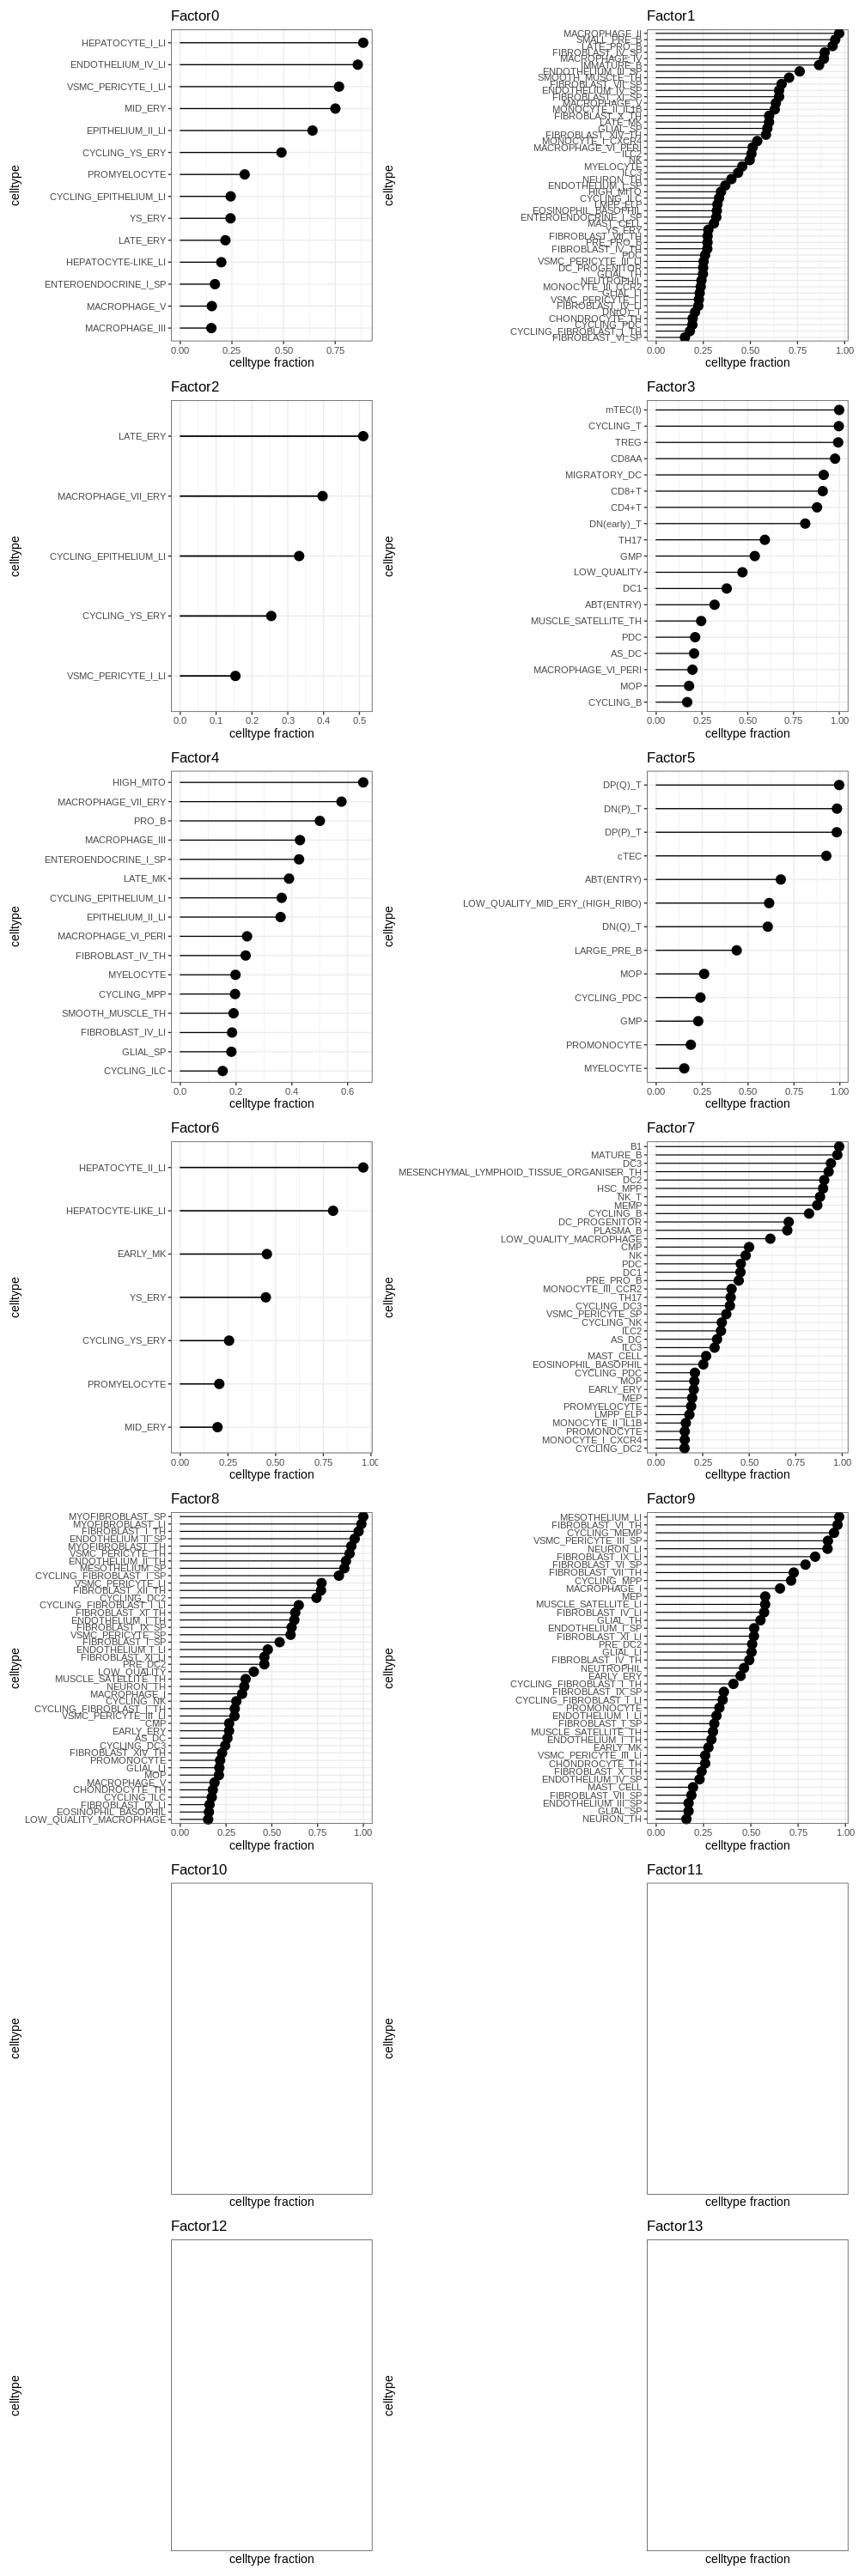

In [33]:
%%R -i nmf_fractions -w 1000 -h 3000 -i figdir
f=4
library(patchwork)
plot_factor_id <- function(f, min_frac= 0.1){
    nmf_frac_df <- nmf_fractions %>%
        rownames_to_column('celltype') %>%
         pivot_longer(cols=-celltype, names_to="factor") %>%
        mutate(factor=str_remove(factor, 'mean_cell_type_factors')) 
    pl <- nmf_frac_df %>%
     filter(factor==paste0('fact_',f)) %>%
        filter(value > min_frac) %>%
        arrange(value) %>%
        mutate(celltype=factor(celltype, levels=celltype)) %>%
        ggplot(aes(value, celltype)) +
        geom_point(size=5) +
        geom_col(color='black', width=0.01) +
        theme_bw(base_size=14) +
        xlab("celltype fraction") +
        ggtitle(paste0("Factor", f))
    return(pl)
    }

pl_ls <- lapply(0:13, function(i) plot_factor_id(i, min_frac=0.15))
wrap_plots(pl_ls, ncol=2) +
ggsave(paste0(figdir, "multiorgan_factors_n_fact14_factorIDs.pdf"), height=30, width=15)

In [36]:
coloc_df = get_colocation_from_nmf(adata_vis_full, vis_sample_metadata_full, multiorgan_c2l_outdir, n_factors=n, min_frac = 0.15, detection_thresh=0.15)

In [39]:
coloc_df

,fact_0,fact_1,fact_2,fact_3,fact_4,fact_5,fact_6,fact_7,fact_8,fact_9
ENDOTHELIUM_IV_LI,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPITHELIUM_II_LI,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
MID_ERY,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENTEROENDOCRINE_I_SP,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
LATE_ERY,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
CYCLING_MEMP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
VSMC_PERICYTE_III_SP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
MESOTHELIUM_LI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
FIBROBLAST_VI_TH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
coloc_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/tmp/c2l_multiorgan_colocation.csv')

<AxesSubplot:>

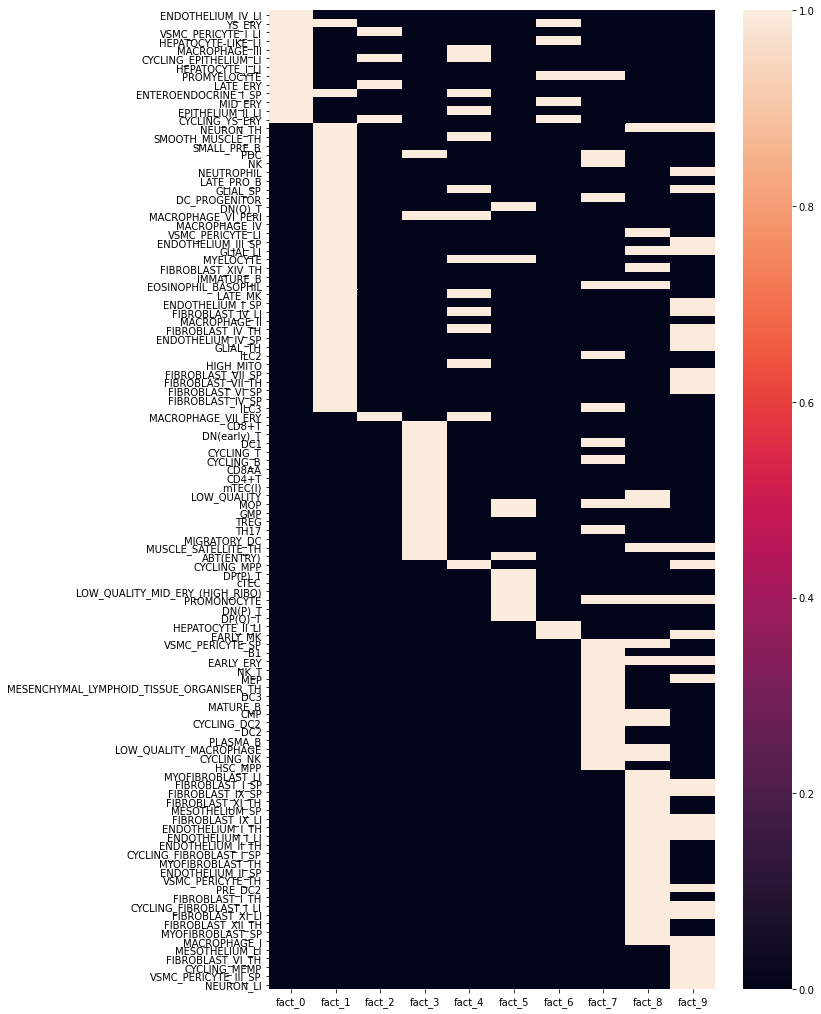

In [40]:
plt.rcParams['figure.figsize'] = 10,18
col_order = coloc_df.idxmax(1).sort_values().index
coloc_df = coloc_df.loc[col_order]
sns.heatmap(coloc_df, yticklabels=True)